# Speed Calculation
The data set for this notebook was captured with a Garmin bike computer during the Great Dublin Bike Ride in September 2015.  The data is time stamped and includes GPS location, distance, heart rate, cycle cadence and altitude.  The data file contains over 16,000 data points relating to about 5 hours of activity.  The data source was transformed so that there is a constant interval of one second between all data points.

This notebook first calculates raw speed based on distance moved in one second.  It zooms in to one minute data windows centred on the top raw speed and second highest raw speed.

It then calculates speed based on a three second rolling average. 

The two different methods can produce very different measures of speed.  The finding is that the three second rolling average gives the most accurate representation of speed.

## Setups

In [2]:
#Import Python Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from pytz import common_timezones, all_timezones, timezone

In [3]:
# Define name and path of data file
# This data file contains a sub-set of activiy information relating to speed and time

input_file = 'activity_speed_ts.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )

input_file_path = os.path.join(input_dir , input_file)

print ("Input file is (full path)  ", input_file_path)

Input file is (full path)   /opt/jupyter/data/csv/activity_speed_ts.csv


In [4]:
# Load data file into a Pandas data frame for inspection
# The dataframe is indexed on time - time variant data
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)
# check column names
df.columns

Index(['distance_diff', 'time_diff', 'speed_raw', 'moving', 'breaks', 'speed_raw_ts', 'distance_ts'], dtype='object')

In [5]:
# Set timezone of source data in Pandas, because time zone data is missing in CSV file
# Time Data in CSV file is UTC 
tz_source = 'UTC'
# Set timezone in our data frame
df = df.tz_localize( tz_source )

In [6]:
# The activity took place in Dublin, Ireland
# Local time is not UTC, its 'Europe/Dublin'
tz_local = timezone('Europe/Dublin')
# Convert data frame to local Time Zone
df = df.tz_convert(tz_local  )
df.head()

,distance_diff,time_diff,speed_raw,moving,breaks,speed_raw_ts,distance_ts
time,,,,,,,
2015-09-13 07:25:51+01:00,0,1,0,False,False,0.0000,0.000
2015-09-13 07:25:52+01:00,NaN,NaN,NaN,True,False,16.6176,4.616
2015-09-13 07:25:53+01:00,NaN,NaN,NaN,True,False,16.6176,4.616
2015-09-13 07:25:54+01:00,NaN,NaN,NaN,True,False,16.6176,4.616
2015-09-13 07:25:55+01:00,NaN,NaN,NaN,True,False,16.6176,4.616


## Exploring the Imported Data Set

The fitness data consists of time series data with a constant one second time interval between data points.

The data points relates contain the following variables:
* distince_diff - the distance travelled since the last data point
* time_diff - the number of seconds
* speed_raw - measured in km/hr, calculated using formula (distance_diff / time_diff) * 3.6
* moving - if the data point represents movement then True.  If the user is at rest then False
* breaks - Set to True if the using is at rest and taking a break from activity

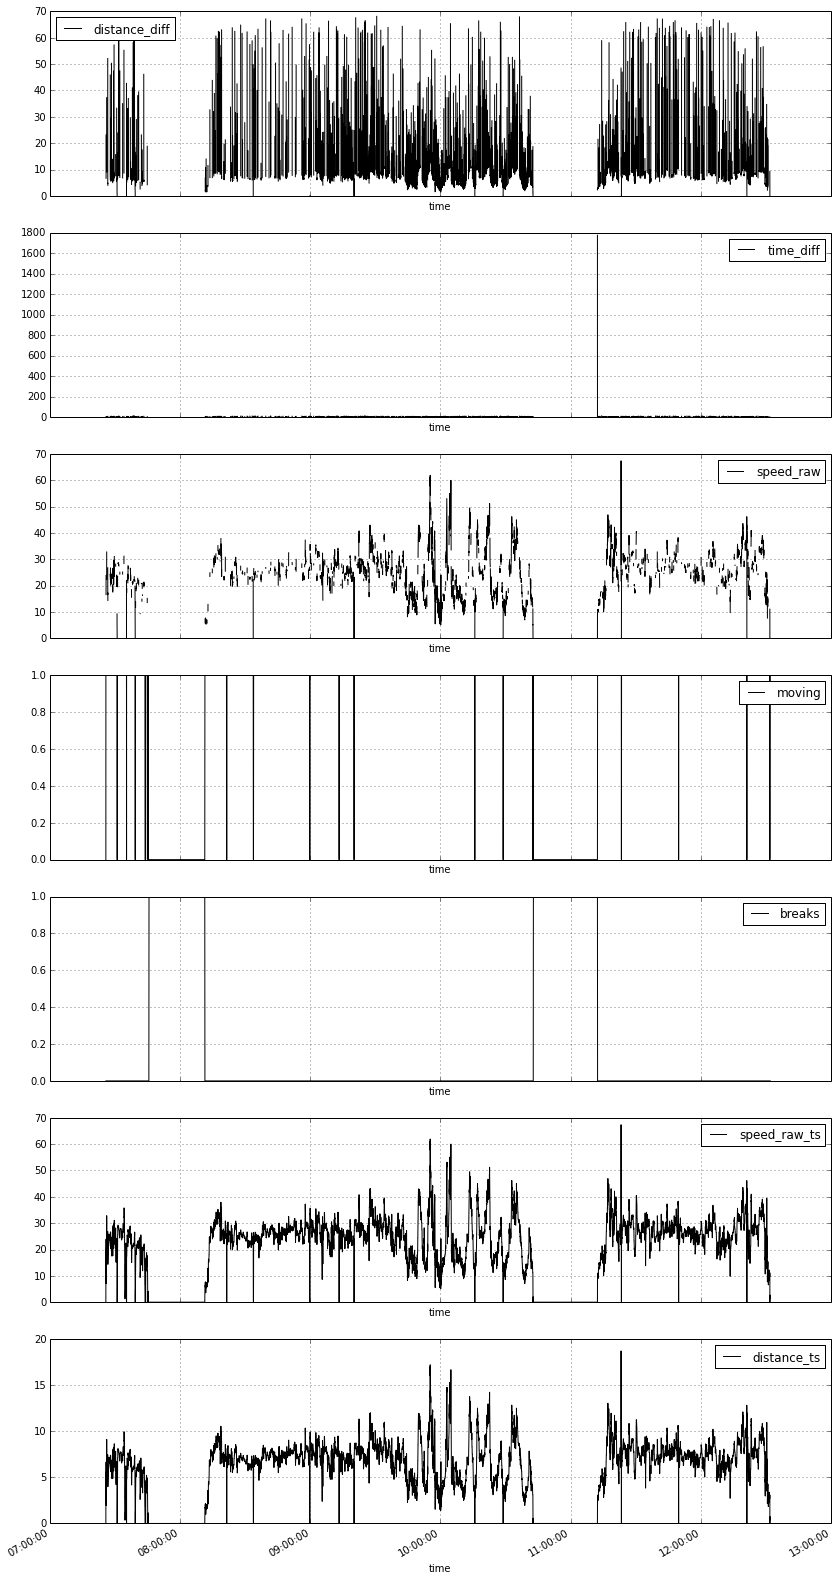

In [49]:
#plot all columns
_ = df.plot(subplots=True, 
        figsize=(14, 30),
         xlim=(datetime(2015,9,13,6,0,0),datetime(2015,9,13,12,0,0 )),
        )


In [50]:
# get statistical summary
df.describe()

,distance_diff,time_diff,speed_raw,moving,breaks,speed_raw_ts,distance_ts
count,5358.000000,5358.000000,5358.000000,18372,18372,18372.000000,18372.000000
mean,19.660904,3.428891,25.820063,0.8134661,0.1807642,20.641527,5.733758
std,18.063191,32.195810,9.102339,0.3895475,0.3848332,11.776201,3.271167
min,0.000000,1.000000,0.000000,False,False,0.000000,0.000000
25%,6.931396,1.000000,20.300000,1,0,14.371875,3.992188
50%,11.113281,1.000000,25.900000,1,0,24.623438,6.839844
75%,28.084473,4.000000,30.800000,1,0,28.125000,7.812500
max,68.839844,1775.000000,67.400000,True,True,67.359375,18.710938


The histogram below shows that most common time interval between data points is 1 second.
However many data points have multiple seconds between data points.


## Exploring the Raw Speed Data

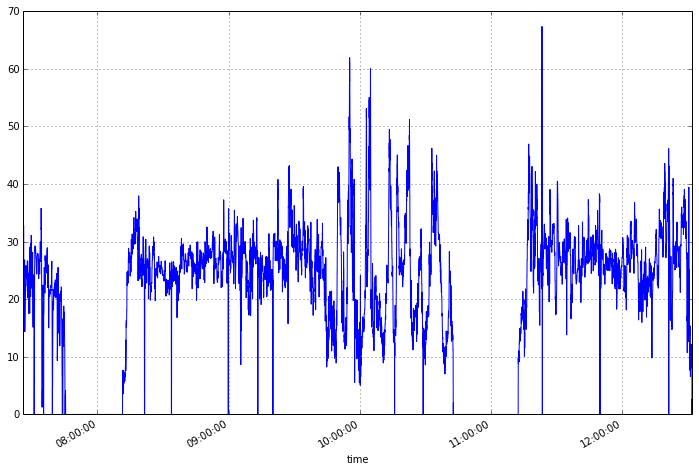

In [51]:
#Plot the speed data for all data points
_ = df['speed_raw_ts'].plot(figsize=(12,8),)

The plot of raw speed shows a number of speed spikes.  Lets explore the speed spikes greater than 60km/hr

## Exploring Maximum Speed / Speed Spikes

In [7]:
# find the data points where speed is greater than 60km/hour
df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], ascending = False)

,distance_diff,time_diff,speed_raw,moving,breaks,speed_raw_ts,distance_ts
time,,,,,,,
2015-09-13 11:23:16+01:00,18.710938,1,67.4,True,False,67.359375,18.710938
2015-09-13 09:55:19+01:00,17.207031,1,61.9,True,False,61.945312,17.207031
2015-09-13 09:55:17+01:00,17.000000,1,61.2,True,False,61.200000,17.000000
2015-09-13 09:55:16+01:00,16.921875,1,60.9,True,False,60.918750,16.921875
2015-09-13 10:04:51+01:00,16.671875,1,60.0,True,False,60.018750,16.671875


The above query shows that highest speed is recorded at 11:23:16 - only a single point around this time is greater than 60 km/hr. 

The second highest speed is at 09:55:19 - it is clearly part of a cluster of 3 points where speed is greater than 60 km/hr. 


In [8]:
# store the indexes related to max speed in variables
# index_max_speed1 holds time index for max speed
# index_max_speed2 holds time index for second highest speed

index_max_speed1, index_max_speed2 = \
            df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], 
                        ascending = False).index.tolist()[:2]
    
#print('The time index for the maximum speed is ' + str(index_max_speed1))
#print('The time index for the second highest speed is ' + str(index_max_speed2))


### Working with Specific Time Windows

In [13]:
# functions allows us to zoom into specific time windows
def get_window_range(dataframe, center_index, window):
    '''
    Return the index at the start and end of given time window for a specific data frame
    
    Input: 
        dataframe - name of dataframe
        center_index - time index in center of window
        window - time window, interval size in seconds
        
    Output:
        index_start - start index for time window
        index_end - end index
    
    '''
    interval = timedelta(seconds=window/2)
    index_start =  center_index - interval
    index_end = center_index + interval
    
    return index_start, index_end

### Zooming in on a  time window centred around Maximum Raw Speed
We examine a time window centred on 10:18:14    
It consists of 60 data points for a minute time interval

speed data


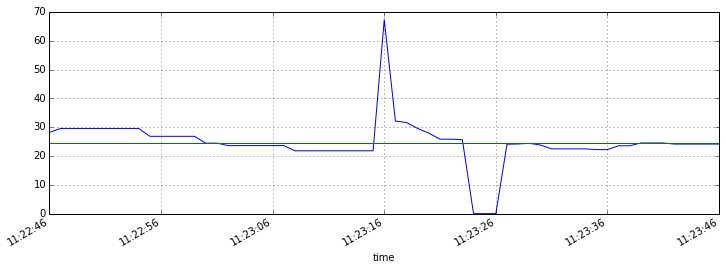

In [12]:
# Here we define the width of the time window in seconds
time_window_seconds = 60

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(df, index_max_speed1, time_window_seconds)

avg_speed = df['speed_raw_ts'][ index_start: index_end ].mean()
max_speed = df['speed_raw_ts'][ index_start: index_end ].max()

plt.figure();
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),)
_ = plt.axhline(avg_speed, color='g')


In [27]:
print("The above diagram shows a data spike.\n\
The max speed of {:.1f} km/h is far in excess of the average speed of {:.1f} km/h"\
     .format( max_speed, avg_speed ))

The above diagram shows a data spike.
The max speed of 67.4 km/h is far in excess of the average speed of 24.6 km/h


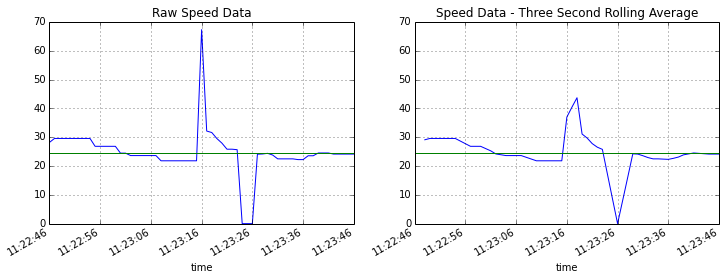

In [59]:
plt.figure() 
plt.subplot(1,2,1)
plt.ylim( (0,70) )
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 3).plot(
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

As can be seen the smoothing function has a dramatic impact on the peak speed -its reduces the maximum speed from almost 70 km/hr to about 45 km/hr.  The smoothing function provides a more realistic representation of the actual speed.

### Exploring the window centred on Second Highest Raw Speed  at 08:55:19

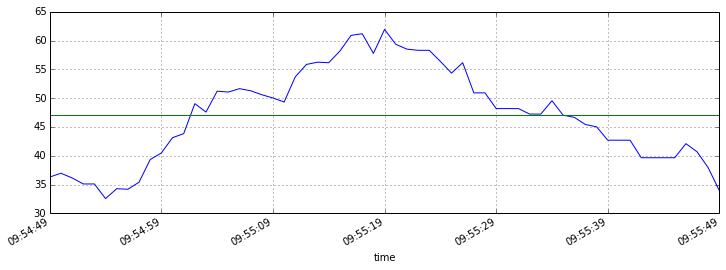

In [60]:
# Here we define the width of the time window in seconds
time_window_seconds = 60

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(df, index_max_speed2, time_window_seconds)

avg_speed = df['speed_raw_ts'][ index_start: index_end ].mean()


plt.figure();
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),)
_ = plt.axhline(avg_speed, color='g')

In [61]:
window_start_time = df.loc[index_start].name.strftime('%H:%M:%S')
window_end_time = df.loc[index_end].name.strftime('%H:%M:%S')
window_duration = ( df.loc[index_end].name - df.loc[index_start].name ).total_seconds()
max_speed = df['speed_raw_ts'][ index_start: index_end ].max()
# check a few data points either side of maximum
#df[ index_start : index_end ][25:35]

print('Window starts at ' + window_start_time  + 
      ', ends at ' + window_end_time +
      ', duration is ' + str(window_duration)  + ' seconds')
print('Average Speed for this period ' + str(avg_speed) )
print('Max Speed for this period ' + str(max_speed) )

Window starts at 09:54:49, ends at 09:55:49, duration is 60.0 seconds
Average Speed for this period 47.129892418
Max Speed for this period 61.9453125


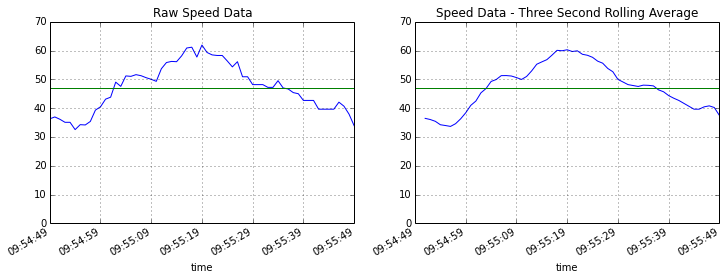

In [63]:
plt.figure() 
plt.subplot(1,2,1)
plt.ylim( (0,70) )
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 3).plot(
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

Smoothing function accurately smooths the speed data.  It makes no dramatic changes - just provides a subtle data smoothing.

## Calculate Rolling Avg Speed and Save to Time Series

In [64]:
# having experimented with different values, 
# a smoothing window size of 3 seconds appears to provide best results
window_size_seconds = 3

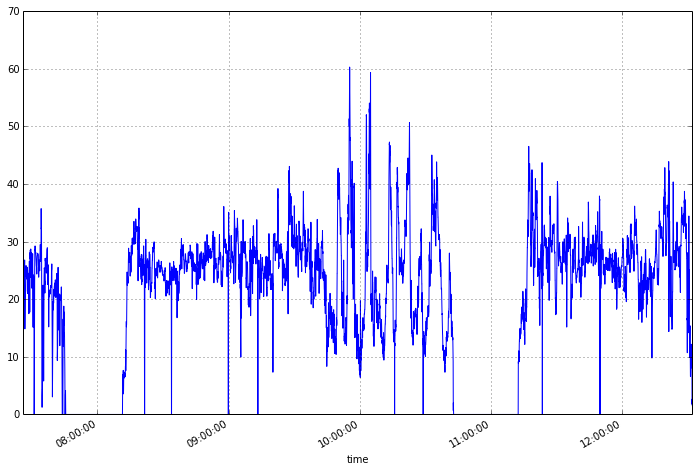

In [65]:
# graph of rolling average speed
_ = pd.rolling_mean( df['speed_raw_ts'] , window_size_seconds )\
                    .fillna(0.0).plot(figsize=(12,8),)

In [66]:
# Save rolling average speed to the time series data set
df['speed_rollavg'] = pd.rolling_mean( df['speed_raw_ts'] , \
                                               window_size_seconds ).fillna(0.0)

In [67]:
# view data series
df[ df['speed_rollavg'] > 58.0]\
        .sort(columns = ['speed_rollavg'], ascending = False)

,distance_diff,time_diff,speed_raw,moving,breaks,speed_raw_ts,distance_ts,speed_rollavg
time,,,,,,,,
2015-09-13 09:55:19+01:00,17.207031,1,61.9,True,False,61.945312,17.207031,60.309375
2015-09-13 09:55:17+01:00,17.000000,1,61.2,True,False,61.200000,17.000000,60.107813
2015-09-13 09:55:18+01:00,16.050781,1,57.8,True,False,57.782812,16.050781,59.967188
2015-09-13 09:55:21+01:00,16.257812,1,58.5,True,False,58.528125,16.257812,59.948438
2015-09-13 09:55:20+01:00,16.492188,1,59.4,True,False,59.371875,16.492188,59.700000
2015-09-13 10:04:52+01:00,16.371094,1,58.9,True,False,58.935938,16.371094,59.376563
2015-09-13 09:55:22+01:00,NaN,NaN,NaN,True,False,58.324219,16.201172,58.741406
2015-09-13 09:55:16+01:00,16.921875,1,60.9,True,False,60.918750,16.921875,58.429688
2015-09-13 09:55:23+01:00,32.402344,2,58.3,True,False,58.324219,16.201172,58.392188


In [68]:
# run original query, checking raw speed and new rolling avg speed
df[ df['speed_raw'] > 60.0].sort(columns = ['speed_raw'], ascending = False)

,distance_diff,time_diff,speed_raw,moving,breaks,speed_raw_ts,distance_ts,speed_rollavg
time,,,,,,,,
2015-09-13 11:23:16+01:00,18.710938,1,67.4,True,False,67.359375,18.710938,37.000781
2015-09-13 09:55:19+01:00,17.207031,1,61.9,True,False,61.945312,17.207031,60.309375
2015-09-13 09:55:17+01:00,17.000000,1,61.2,True,False,61.200000,17.000000,60.107813
2015-09-13 09:55:16+01:00,16.921875,1,60.9,True,False,60.918750,16.921875,58.429688


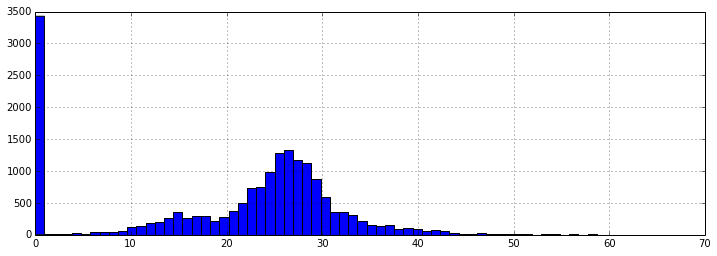

In [69]:
#check the frequency distribution of raw speed data variables
_ = df['speed_raw_ts'].hist(bins=70,
                figsize=(12,4),)

In [57]:
window_start_time = df.loc[index_start].name.strftime('%H:%M:%S')
window_end_time = df.loc[index_end].name.strftime('%H:%M:%S')
window_duration = ( df.loc[index_end].name - df.loc[index_start].name ).total_seconds()
max_speed = df['speed_raw_ts'][ index_start: index_end ].max()

# check a few data points either side of maximum
#df[ index_start : index_end ][25:35]

print('Window starts at ' + window_start_time  + 
      ', ends at ' + window_end_time +
      ', duration is ' + str(window_duration)  + ' seconds')
print('Average Speed for this period ' + str(avg_speed) )
print('Max Speed for this period ' + str(max_speed) )

Window starts at 11:22:46, ends at 11:23:46, duration is 60.0 seconds
Average Speed for this period 24.6383809646
Max Speed for this period 67.359375
